<a href="https://colab.research.google.com/github/arshadblouch81/Kinship/blob/main/Kinship_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image
target_shape = (200, 200)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/Coding/

/content/drive/MyDrive/Coding


In [27]:
def getBalancedFileList(path_dir):
  listOfFile = os.listdir(path_dir)   
  #print(listOfFile)
  allFiles = []
    # Iterate over all the entries
  num=0;
  def image_file(f):
	  return f.endswith('.png') or f.endswith('.jpg') 
  for entry in listOfFile:
     # Create full path       
     fullPath = os.path.join(path_dir, entry)
   
     for r, d, files in os.walk(fullPath):
       if len(files)==0:
           continue;    
       an_iterator = filter(image_file, files)
       files_filtered=list(an_iterator)
       if len(files_filtered)>0:
         for f in random.choices(files,k=5):
            allFiles.append(os.path.join(r,f))
  return allFiles

In [28]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    num=0;
    for entry in listOfFile:
        # Create full path       
               
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)         
        else:
            #if entry=='mid.csv': 
             allFiles.append(fullPath)
               
                
    return allFiles

In [29]:
cache_dir =  '/content/drive/MyDrive/Coding/FIW_M'
father_images_path =  "/MID1/"
mother_images_path =  "/MID2/"
kids_images_path =  "/MID3/"
kids_images_path2 =  "/MID4/"
kids_images_path3 =  "/MID5/"

In [30]:

lst=getBalancedFileList(cache_dir)
lst=sorted(lst)


In [33]:
kids_images=[]
father_images=[]
mother_images=[]


for f in getBalancedFileList(cache_dir):
  if (kids_images_path in f):
    kids_images.append(f)
  elif (father_images_path in f):
    father_images.append(f) 
  elif (mother_images_path in f):
    mother_images.append(f)  

In [34]:
kids_images= sorted(kids_images)
father_images= sorted(father_images)
mother_images= sorted(mother_images)

In [36]:
print(len(kids_images))
print(len(father_images))
print(len(mother_images))

150
150
150


In [37]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [38]:
# We need to make sure both the anchor and positive images are loaded in
# sorted order so we can match them together.

anchor=father_images
positive=kids_images
negative=mother_images

image_count = len(anchor)


anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative)


dataset = tf.data.Dataset.zip((anchor_dataset,positive_dataset, negative_dataset))
#dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

In [40]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(3, 3))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])



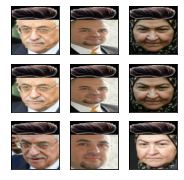

In [41]:
visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [42]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

94781440/94765736 [==============================] - 1s 0us/step


In [43]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [44]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [45]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
4/4 [==============================] - 101s 24s/step - loss: 0.6038 - val_loss: 0.5139
Epoch 2/10
4/4 [==============================] - 82s 21s/step - loss: 0.2806 - val_loss: 0.5120
Epoch 3/10
4/4 [==============================] - 82s 21s/step - loss: 0.1614 - val_loss: 0.6145
Epoch 4/10
4/4 [==============================] - 82s 21s/step - loss: 0.0801 - val_loss: 0.9205
Epoch 5/10
4/4 [==============================] - 84s 21s/step - loss: 0.0395 - val_loss: 1.1558
Epoch 6/10
4/4 [==============================] - 84s 21s/step - loss: 0.0575 - val_loss: 1.4273
Epoch 7/10
4/4 [==============================] - 83s 21s/step - loss: 0.0511 - val_loss: 1.3430
Epoch 8/10
4/4 [==============================] - 83s 21s/step - loss: 0.0505 - val_loss: 1.4624
Epoch 9/10
4/4 [==============================] - 84s 21s/step - loss: 0.0303 - val_loss: 1.4192
Epoch 10/10
4/4 [==============================] - 83s 21s/step - loss: 0.0484 - val_loss: 1.4381


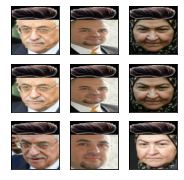

In [46]:
sample = next(iter(train_dataset))
visualize(*sample)

kids, father, mother = sample
father_embedding,kids_embedding, mother_embedding = (
      embedding(resnet.preprocess_input(kids)),
      embedding(resnet.preprocess_input(father)),
      embedding(resnet.preprocess_input(mother)),
  )

In [47]:
cosine_similarity = metrics.CosineSimilarity()

father_similarity = cosine_similarity(kids_embedding, father_embedding)
print("Similarity with Father:", father_similarity.numpy())

mother_similarity = cosine_similarity(kids_embedding, mother_embedding)
print("Similarity with Mother", mother_similarity.numpy())


Similarity with Father: 0.99960333
Similarity with Mother 0.9995351


In [49]:
test_dir='/content/drive/MyDrive/Coding/FIW_Test'
tkids_images=[]
tfather_images=[]
tmother_images=[]
for f in getListOfFiles(test_dir):
  if (kids_images_path in f):
    tkids_images.append(f)
  if (father_images_path in f):
    tfather_images.append(f) 
  if (mother_images_path in f):
    tmother_images.append(f)  


In [50]:
tkids_images= sorted(tkids_images)
tfather_images= sorted(tfather_images)
tmother_images= sorted(tmother_images)

In [51]:

tkids_dataset = tf.data.Dataset.from_tensor_slices(tkids_images)
tfather_dataset = tf.data.Dataset.from_tensor_slices(tfather_images)
tmother_dataset = tf.data.Dataset.from_tensor_slices(tmother_images)


tdataset = tf.data.Dataset.zip((tkids_dataset, tfather_dataset, tmother_dataset))
#dataset = dataset.shuffle(buffer_size=1024)
tdataset = tdataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
test_dataset = tdataset.take(round(image_count * 1))

test_dataset = test_dataset.batch(3, drop_remainder=False)
test_dataset = test_dataset.prefetch(8)




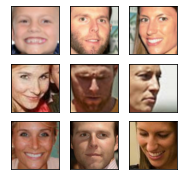

In [52]:
visualize(*list(test_dataset.take(1).as_numpy_iterator())[0])

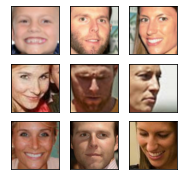

In [60]:
sample = next(iter(test_dataset))
visualize(*sample)

In [61]:
results=siamese_model.predict(sample)
print(results)

(array([5.253029  , 1.5669367 , 0.73827183], dtype=float32), array([3.096934 , 4.4141674, 1.9413464], dtype=float32))


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()